In [ ]:
import cv2

import numpy as np
import skimage
from skimage.color import rgb2gray
from skimage.filters import frangi
import matplotlib.pyplot as plt
import streamlit as st
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from skimage.exposure import rescale_intensity
from imblearn.metrics import sensitivity_score
from imblearn.metrics import specificity_score
import math

In [ ]:
    #Oddzielenie kanałów kolorów, aby zobaczyć, który kanał wydaje się najlepiej pokazywać naczynia:
    image_input = cv2.imread('01_h.jpg')
    image_blue = image_input[:,:,0]
    image_green = image_input[:,:,1]
    image_red = image_input[:,:,2]
    
    plt.figure(figsize=(20,12))
    plt.subplot(141)
    plt.imshow(image_input[:,:,::-1]);
    plt.title("oryginalny obraz")
    plt.subplot(142)
    plt.imshow(image_blue, cmap='gray');
    plt.title("kanał niebieski")
    plt.subplot(143)
    plt.imshow(image_green, cmap='gray');
    plt.title("kanał zielony")
    plt.subplot(144)
    plt.imshow(image_red, cmap='gray');
    plt.title("kanał czerwony");

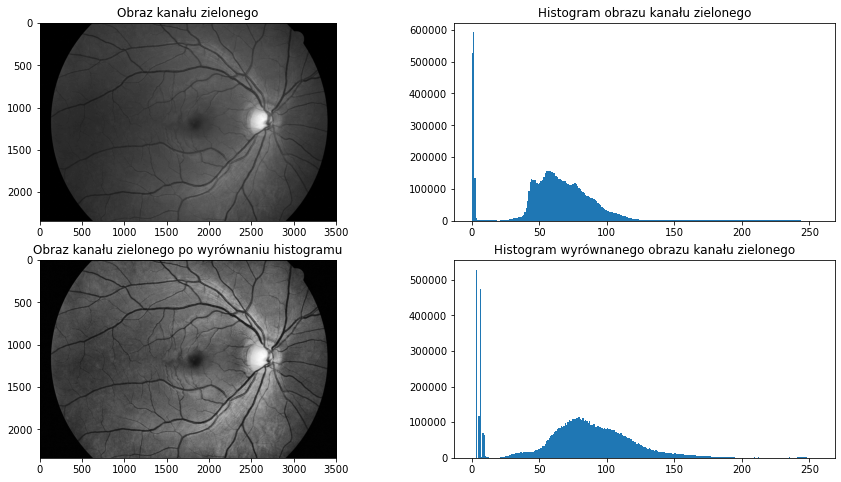

In [9]:
    #Wyrównywanie histogramu obrazu za pomocą adaptacyjnego wyrównywania histogramu z ograniczonym kontrastem:
    #https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_equalization/py_histogram_equalization.html
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    image_green_equalized = clahe.apply(image_green)
    
    fig=plt.figure(figsize=(15, 8))
    plt.subplot(221)
    plt.imshow(image_green, cmap='gray')
    plt.title("Obraz kanału zielonego")
    plt.subplot(222)
    plt.hist(image_green.ravel(),256,[0,256])
    plt.title("Histogram obrazu kanału zielonego")

    plt.subplot(223)
    plt.imshow(image_green_equalized, cmap='gray')
    plt.title("Obraz kanału zielonego po wyrównaniu histogramu")
    plt.subplot(224)
    plt.hist(image_green_equalized.ravel(),256,[0,256])
    plt.title("Histogram wyrównanego obrazu kanału zielonego")
    plt.show()


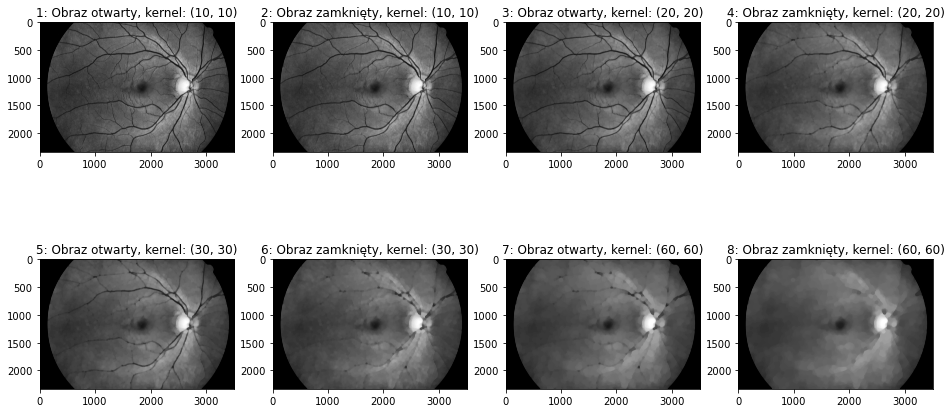

In [10]:
# Operacje morfologiczne w celu wydobycia tła
kernel_sizes = [10,20,30,60]
kernels = [cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(size, size)) for size in kernel_sizes]

morphology_steps = [image_green_equalized.copy()]
for kernel in kernels:
    image_opened = cv2.morphologyEx(morphology_steps[-1], cv2.MORPH_OPEN, kernel, iterations = 1)
    image_closed = cv2.morphologyEx(image_opened, cv2.MORPH_CLOSE, kernel, iterations = 1)
    morphology_steps.extend([image_opened, image_closed])

fig=plt.figure(figsize=(16, 8))
rows = 2
columns = len(kernels)
for i in range(1, len(morphology_steps)):
    img = morphology_steps[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    kernel_size = kernel_sizes[math.ceil(i/2)-1]
    if i%2==1:
        plt.title("%d: Obraz otwarty, kernel: (%d, %d)" % (i, kernel_size, kernel_size))
    else:
        plt.title("%d: Obraz zamknięty, kernel: (%d, %d)" % (i, kernel_size, kernel_size))
plt.show()

Text(0.5, 1.0, 'Wyodrębnione naczynie')

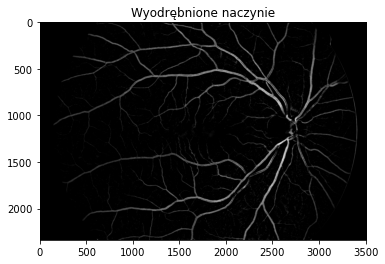

In [11]:
#Odejmujemy tło od naszych obrazów (technicznie robimy coś przeciwnego, ponieważ białe piksele są największą wartością):
extracted_vessels = cv2.subtract(morphology_steps[-1],image_green_equalized)
plt.imshow(extracted_vessels, cmap='gray')
plt.title("Wyodrębnione naczynie")

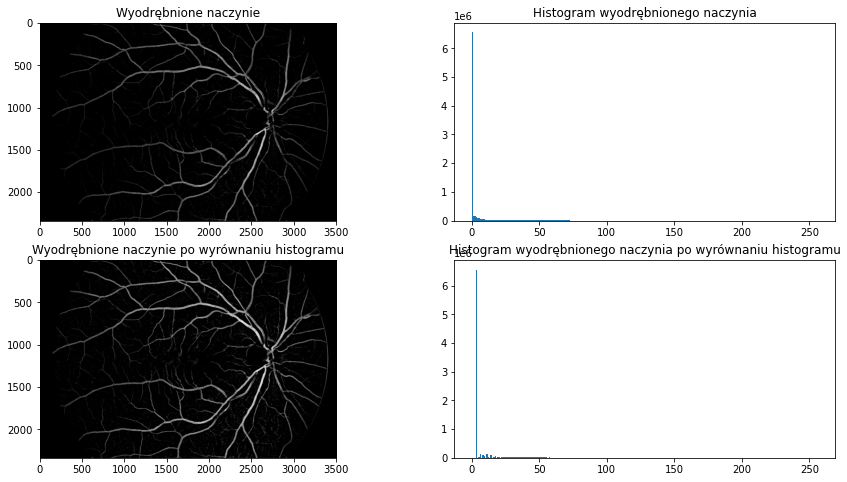

In [12]:
#Wyrównywanie histogramu obrazu za pomocą adaptacyjnego wyrównywania histogramu z ograniczonym kontrastem:
extracted_vessels_equalized = clahe.apply(extracted_vessels)

fig=plt.figure(figsize=(15, 8))

plt.subplot(221)
plt.imshow(extracted_vessels, cmap='gray')
plt.title("Wyodrębnione naczynie")
plt.subplot(222)
plt.hist(extracted_vessels.ravel(),256,[0,256])
plt.title("Histogram wyodrębnionego naczynia")

plt.subplot(223)
plt.imshow(extracted_vessels_equalized, cmap='gray')
plt.title("Wyodrębnione naczynie po wyrównaniu histogramu")
plt.subplot(224)
plt.hist(extracted_vessels_equalized.ravel(),256,[0,256])
plt.title("Histogram wyodrębnionego naczynia po wyrównaniu histogramu")

plt.show()

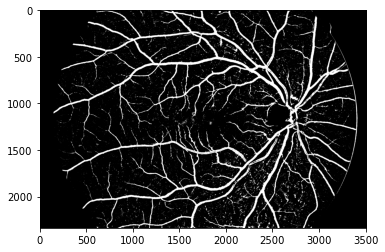

In [13]:
#Progujemy naczynia:
ret,extracted_vessels_equalized_threshold = cv2.threshold(extracted_vessels_equalized,20,255,cv2.THRESH_BINARY)
plt.imshow(extracted_vessels_equalized_threshold,cmap='gray')

(2336, 3504)


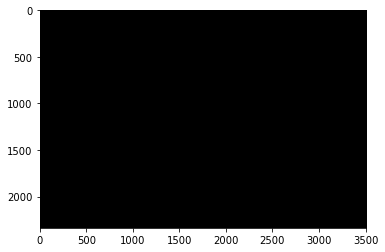

In [14]:
#Jest dużo hałasu, którego musimy się pozbyć.
#Wiemy, że naczynia są połączone dość długimi liniami,
#Szumy możemy odfiltrować za pomocą obszaru konturów.

noise_mask = np.ones(extracted_vessels_equalized.shape[:2], dtype="uint8") * 255
plt.imshow(noise_mask,cmap='gray')
print(np.shape(noise_mask))

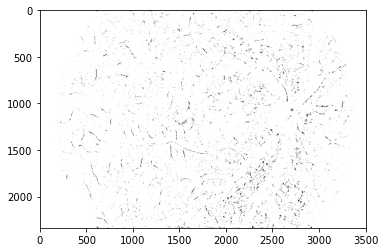

In [15]:
#Rysujemy wszystkie kontury, których chcemy się pozbyć, których obszar jest poniżej pewnej wartości progowej:
contours, hierarchy = cv2.findContours(extracted_vessels_equalized_threshold.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:
    if cv2.contourArea(contour) <= 200:
        cv2.drawContours(noise_mask, [contour], -1, 0, -1)
plt.imshow(noise_mask, cmap='gray')

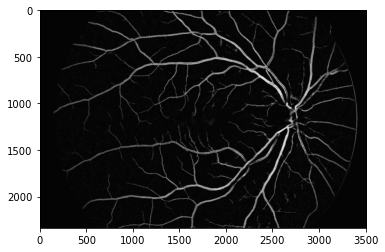

In [16]:
#Używamy maski na naszym obrazie:
extracted_vessels_corrected = cv2.bitwise_and(extracted_vessels_equalized, extracted_vessels_equalized, mask=noise_mask)
plt.imshow(extracted_vessels_corrected, cmap='gray')

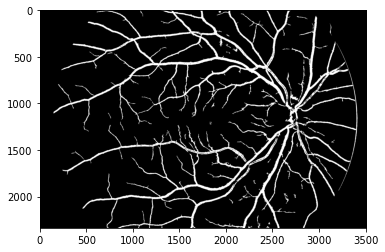

In [17]:
#Ponownie progujemy naczynia:
ret,extracted_vessels_corrected_thresholded = cv2.threshold(extracted_vessels_corrected,20,255,cv2.THRESH_BINARY)
plt.imshow(extracted_vessels_corrected_thresholded, cmap='gray')

In [18]:
# Po uzyskaniu zadowalających wyników z powyższych działań tworzymy jedną funkcję:
def get_vessels(image, kernel_sizes = [5,7,15,21], thresh_val=20, max_noise_area=200):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

    image_green = image[:,:,1]
    image_green_equalized = clahe.apply(image_green)
    
    kernels = [cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(size, size)) for size in kernel_sizes]

    morphology_steps = [image_green_equalized.copy()]
    for kernel in kernels:
        image_opened = cv2.morphologyEx(morphology_steps[-1], cv2.MORPH_OPEN, kernel, iterations = 1)
        image_closed = cv2.morphologyEx(image_opened, cv2.MORPH_CLOSE, kernel, iterations = 1)
        morphology_steps.extend([image_opened, image_closed])

    extracted_vessels = cv2.subtract(morphology_steps[-1],image_green_equalized)
    extracted_vessels_equalized = clahe.apply(extracted_vessels)
    _, extracted_vessels_equalized_threshold = cv2.threshold(extracted_vessels_equalized,thresh_val,255,cv2.THRESH_BINARY)
    
    noise_mask = np.ones(extracted_vessels_equalized_threshold.shape[:2], dtype="uint8") * 255

    contours, hierarchy = cv2.findContours(extracted_vessels_equalized_threshold.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) <= max_noise_area:
            cv2.drawContours(noise_mask, [contour], -1, 0, -1)

    extracted_vessels_corrected = cv2.bitwise_and(extracted_vessels_equalized, extracted_vessels_equalized, mask=noise_mask)
    _, extracted_vessels_corrected_thresholded = cv2.threshold(extracted_vessels_corrected,thresh_val,255,cv2.THRESH_BINARY)
    return extracted_vessels_corrected_thresholded

In [19]:

input_filename_list = ['01_h.jpg','02_h.jpg','03_h.jpg','04_h.jpg','05_h.jpg']
vessels_filename_list = ['01_h.tif','02_h.tif','03_h.tif','04_h.tif','05_h.tif']
image_list = []
i = 0
while i< len(input_filename_list):
    image = cv2.imread(input_filename_list[i])
    image_list.appcv2end(image)  
    i+=1
    
image_vessels_list = []
bw_image_vessels_list = []
j = 0
while j< len(vessels_filename_list):
    image = cv2.imread(vessels_filename_list[j])
    image_vessels_list.append(image)  
    
    ret,extracted_vessels_corrected_thresholded = cv2.threshold(image,20,255,cv2.THRESH_BINARY)
    bw_image_vessels_list.append(extracted_vessels_corrected_thresholded)
    j+=1

image_processed_list = []
bw_image_processed_list = []
k = 0
while k< len(input_filename_list):
    image_processed_list.append(get_vessels(image_list[k]))
    ret,extracted_vessels_corrected_thresholded = cv2.threshold(image,20,255,cv2.THRESH_BINARY)
    bw_image_processed_list.append(extracted_vessels_corrected_thresholded)
    k+=1


In [20]:
def get_metrics(img_test, img_pred):
    conf = confusion_matrix(img_test.flatten(), img_pred.flatten())
    TN, FP, FN, TP = conf.ravel()
    
    accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    sensitivity = (TP / float(TP + FN))
    specificity = (TN / float(TN + FP))
    geo_mean_val = (sensitivity*specificity)**(1.0/2)
    
    return (accuracy, sensitivity, specificity, geo_mean_val)  


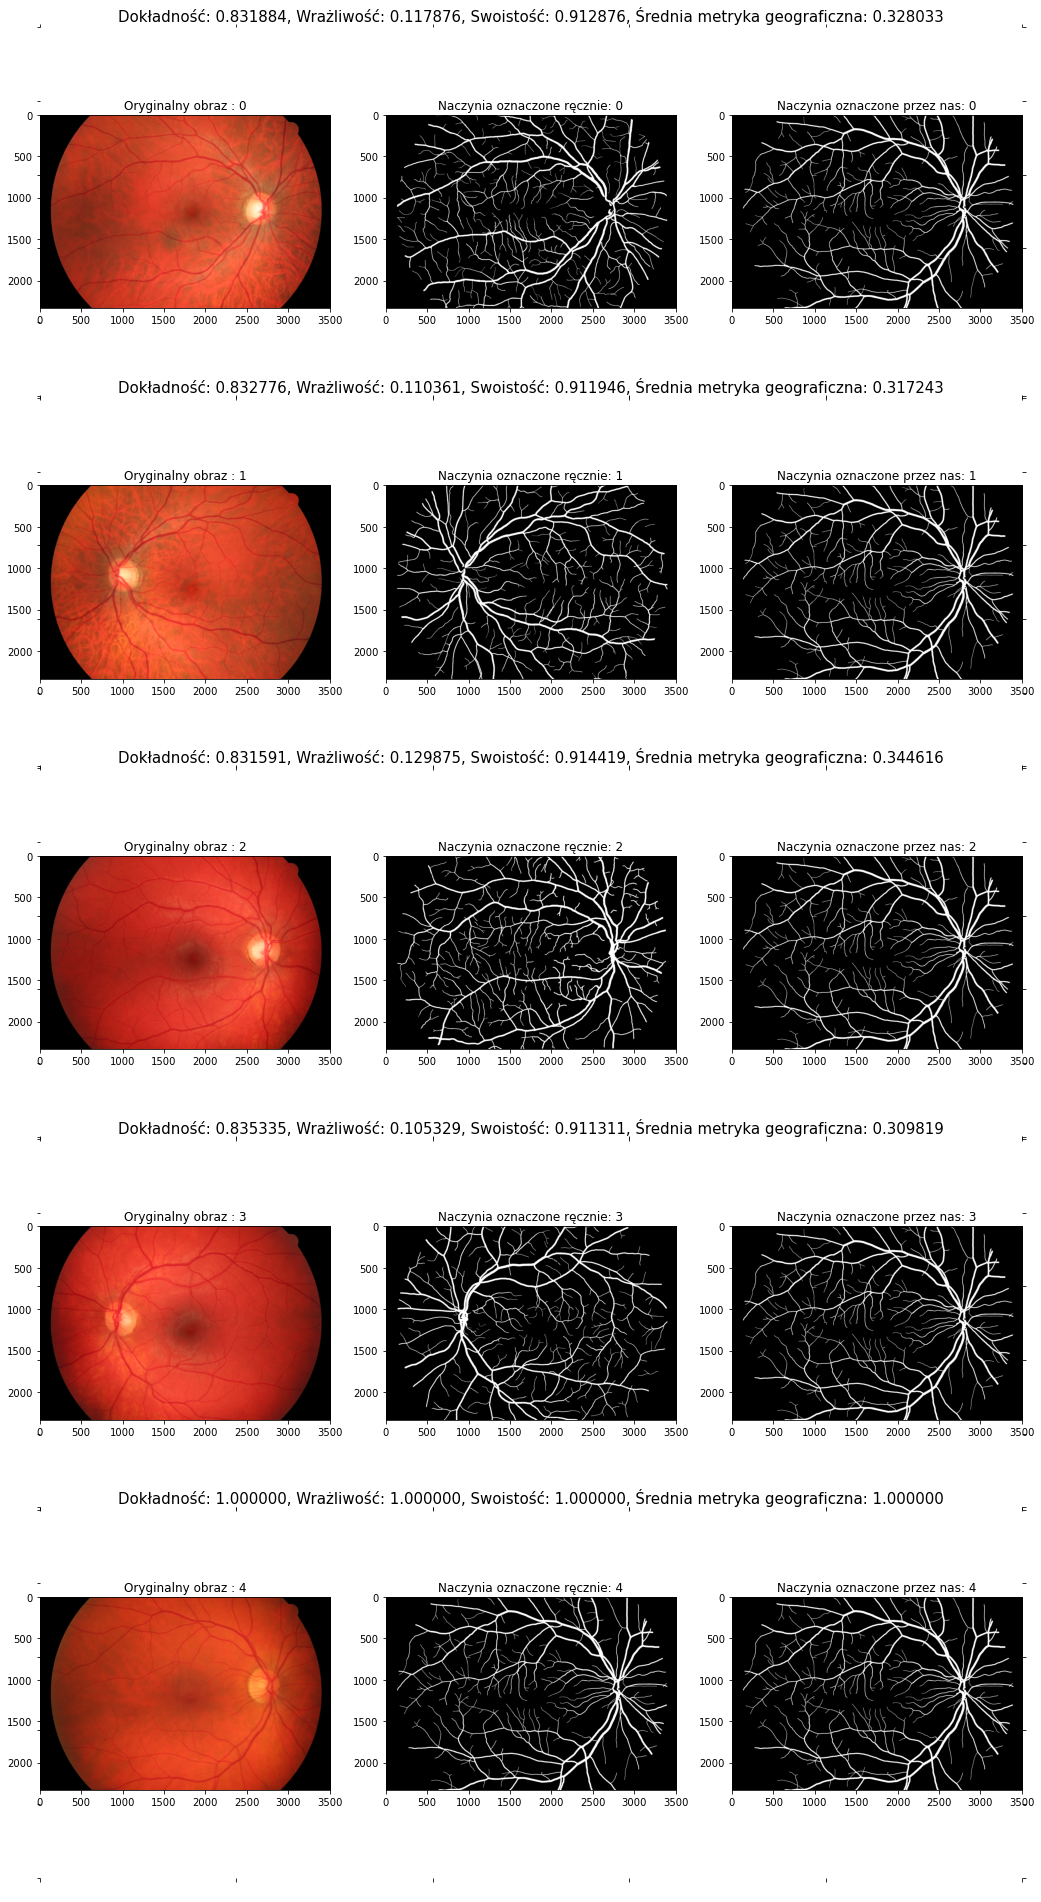

In [21]:
columns = 3
rows = 5

fig, big_axes = plt.subplots( figsize=(15, 26) , nrows=rows, ncols=1, sharey=True) 

for row, big_ax in enumerate(big_axes, start=1):
    
    
    big_ax.set_title("Dokładność: %f, Wrażliwość: %f, Swoistość: %f, Średnia metryka geograficzna: %f"%get_metrics(bw_image_vessels_list[row-1], bw_image_processed_list[row-1]), fontsize=15)
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    big_ax._frameon = False

for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if i%3==0:
        img = image_list[int(i/3)]
        plt.title("Oryginalny obraz : %d" % int(i/3))
        plt.imshow(img[:,:,::-1])
    elif i%3==1:
        img = bw_image_vessels_list[int(i/3)]
        plt.title("Naczynia oznaczone ręcznie: %d" % int(i/3))
        plt.imshow(img, cmap='gray')
    else:
        img = bw_image_processed_list[int(i/3)]
        plt.title("Naczynia oznaczone przez nas: %d" % int(i/3))
        plt.imshow(img, cmap='gray')

fig.set_facecolor('w')
plt.tight_layout()
plt.show()